<a href="https://colab.research.google.com/github/Sayed-Husain/Natural-Language-Processing-Projects/blob/main/Disaster_Tweets/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification: Disaster Tweets
In this notebook, we are going to bulid:

0. A traditional Machine Learning Model.
1. Simple Deep Learning model 
2. Deep Learning model using Transfer learning

to classify disaster tweets.

We will compare between the results of the three models and use the best one to submit for the Kaggle's competition.

### Problem Definition 

In a statement,

Given Tweets, the model(s) shall detect emerginces/disasters and predicts which Tweets are about real disasters and which one’s aren’t.

### Data
The data is downloaded from the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/).

## Check for a GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b75ea1f5-b9df-6e16-a724-97a695d9fb4c)


## Unzip the dataset

In [4]:
!unzip /content/nlp-getting-started.zip

Archive:  /content/nlp-getting-started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Explore the data

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# View the 5 first rows of the dataset
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Check the size of the dataset
len(train_df), len(test_df)

(7613, 3263)

In [7]:
# What does the test dataset look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# how is the distrbution of the values between classes
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [10]:
# Explore some Tweets
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  print(f"Target: {row.target}", "(real disaster)" if row.target > 0 else "(not disaster)")
  print("---")
  print(f"Text:\n{row.text}")
  print("\n=====\n")

Target: 1 (real disaster)
---
Text:
Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf

=====

Target: 0 (not disaster)
---
Text:
@RyleeDowns02 @nevaehburton33 if I don't get my money by tomorrow rioting ??

=====

Target: 0 (not disaster)
---
Text:
This thunder is beautiful

=====

Target: 0 (not disaster)
---
Text:
Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw

=====

Target: 0 (not disaster)
---
Text:
Aannnnd - 'Reddit Will Now Quarantine Offensive Content' https://t.co/P1JluRGWBu

=====



In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split function to create training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size = 0.1)

In [12]:
# check the sizes of the new sets
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first sample
train_sentences[0], train_labels[0]

('That hellfire song from the hunchback of notre dame reminds me a lot of my house',
 0)

## Convert text into tensors 

### Text Tokenization
Assosiate every word with a number

In [14]:
# Import tensorflow and the TextVectorization layer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [15]:
# Setup text vectorization variables
max_length = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # Get the average number of words in a sentence
max_vocab_length = 2000 # Will only assosiate 2000 words with numbers and leave the rest 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [16]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "Who would have imagined that an earthquake would hit us!"
print(len(sample_sentence.split()))
text_vectorizer([sample_sentence])

10


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 66,  78,  24,   1,  15,  41, 218,  78, 217,  69,   0,   0,   0,
          0,   0]])>

> Notice that though we only have 10 words, the returned vector shows 15 numbers.

### Embedding
Rich numerical representation of relationships betweens tokens

In [19]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length, # Input shape
                      output_dim=128, # Output shape
                      input_length=max_length)

## Modelling

### Create a function to evaluate the models

In [20]:
# Create a function to evaluate the model
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(y_true, y_pred):
  """
  Evaluate model's predictions based on accuracy, precision, recall, and f1-score.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred)
  # Calculate model precision, recall, and f1-score
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

  model_results = {"accuracy" : model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1":model_f1}
  return model_results

### Create a function to plot the history curves

In [21]:
import matplotlib.pyplot as plt
def plot_history_curves(history): 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Model 0: Machine Learning Model
We will use Sklearn's Multinomial Naive Bayes using the TF.IDF formula to convert words to numbers.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
    ("clf", MultinomialNB()), # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [23]:
# Get Machine Learning model evaluation 
model_0_predictions = model_0.predict(val_sentences)
model_0_evaluation = evaluate_model(val_labels, model_0_predictions)
model_0_evaluation

{'accuracy': 0.7926509186351706,
 'precision': 0.8042072756639687,
 'recall': 0.7926509186351706,
 'f1': 0.7855129234364377}

The Machine Learning model is doing pretty good with a 80% accuracy

### Model 1: Simple Deep Learning Model

In [24]:
# Bulid model with Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # The input of the model
x = text_vectorizer(inputs) # Vectorize the text (assosiate words with numbers)
x = embedding(x) # Embed the text
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # The output

# Create the model
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [25]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           256000    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 256,129
Trainable params: 256,129
Non-t

In [26]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [27]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
215/215 [==============================] - 5s 5ms/step - loss: 0.6195 - accuracy: 0.6773 - val_loss: 0.5392 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4762 - accuracy: 0.7951 - val_loss: 0.4680 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 4ms/step - loss: 0.4110 - accuracy: 0.8257 - val_loss: 0.4504 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3752 - accuracy: 0.8403 - val_loss: 0.4469 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.3515 - accuracy: 0.8485 - val_loss: 0.4500 - val_accuracy: 0.7874


In [28]:
# Create prediction
model_1_pred_probs = tf.squeeze(model_1.predict(val_sentences)) # Create prediction probabilities 
model_1_preds = tf.round(model_1_pred_probs) # Convert the prediction probabilites into predictions

# Evaluate model
model_1_results = evaluate_model(val_labels, model_1_preds)
model_1_results

{'accuracy': 0.7874015748031497,
 'precision': 0.7902904866902589,
 'recall': 0.7874015748031497,
 'f1': 0.7832874137203288}

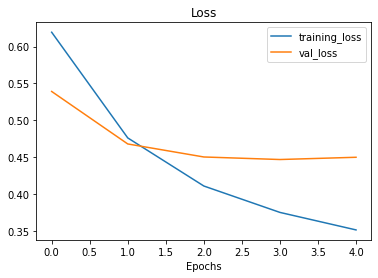

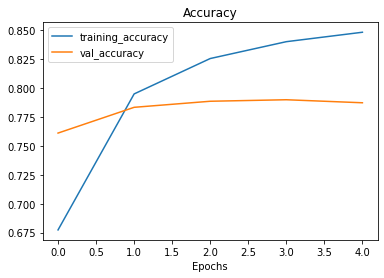

In [29]:
plot_history_curves(model_1_history)

> The plots shows signs of overfitting

In [30]:
# View the most used words
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10]

['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']

### Model 2: Deep Learning Model using TensorFlow Hub Pretrained Sentence Encoder

In [31]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # Use of USE model

# Create a Keras Layers using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", 
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [44]:
# Create a model using the Sequential API
model_2 = tf.keras.Sequential([
    sentence_encoder_layer, # The USE model
    layers.Dense(64, activation="relu"), # Dense Layer
    layers.Dense(1, activation="sigmoid") # Output layer
], name="Model_2_USE")

# Compile 
model_2.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# get summary
model_2.summary()

Model: "Model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [45]:
# Train a classifer on top of the USE pretrained embeddings
model_2_history = model_2.fit(train_sentences,
                              train_labels, 
                              epochs=8,
                              validation_data = (val_sentences, val_labels))

Epoch 1/8
215/215 [==============================] - 4s 12ms/step - loss: 0.5094 - accuracy: 0.7825 - val_loss: 0.4600 - val_accuracy: 0.7769
Epoch 2/8
215/215 [==============================] - 2s 11ms/step - loss: 0.4141 - accuracy: 0.8159 - val_loss: 0.4537 - val_accuracy: 0.7861
Epoch 3/8
215/215 [==============================] - 2s 11ms/step - loss: 0.3994 - accuracy: 0.8237 - val_loss: 0.4535 - val_accuracy: 0.8005
Epoch 4/8
215/215 [==============================] - 2s 11ms/step - loss: 0.3905 - accuracy: 0.8254 - val_loss: 0.4546 - val_accuracy: 0.7979
Epoch 5/8
215/215 [==============================] - 2s 11ms/step - loss: 0.3844 - accuracy: 0.8313 - val_loss: 0.4567 - val_accuracy: 0.8005
Epoch 6/8
215/215 [==============================] - 2s 10ms/step - loss: 0.3790 - accuracy: 0.8327 - val_loss: 0.4555 - val_accuracy: 0.7966
Epoch 7/8
215/215 [==============================] - 2s 11ms/step - loss: 0.3736 - accuracy: 0.8356 - val_loss: 0.4534 - val_accuracy: 0.8018
Epoch 

In [46]:
# Make prediction
model_2_pred_prob = tf.squeeze(model_2.predict(val_sentences))
model_2_preds = tf.round(model_2_pred_prob)

# Evaluate the model
model_2_results = evaluate_model(val_labels, model_2_preds)
model_2_results

{'accuracy': 0.8044619422572179,
 'precision': 0.8044368083249559,
 'recall': 0.8044619422572179,
 'f1': 0.8026886721519416}

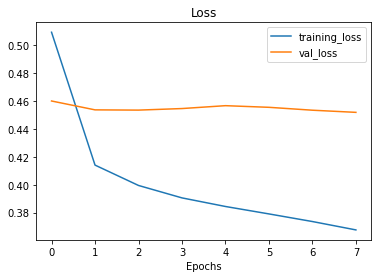

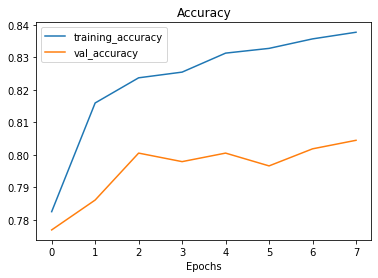

In [47]:
plot_history_curves(model_2_history)

## Compare Models

### Based on scores

In [48]:
# Combine model results into a DataFrame
models_results = pd.DataFrame({"0_ML": model_1_results,
                               "1_simple_DL": model_1_results,
                               "2_transfer_learning": model_2_results})

models_results = models_results.T
models_results

,accuracy,precision,recall,f1
0_ML,0.787402,0.790290,0.787402,0.783287
1_simple_DL,0.787402,0.790290,0.787402,0.783287
2_transfer_learning,0.804462,0.804437,0.804462,0.802689


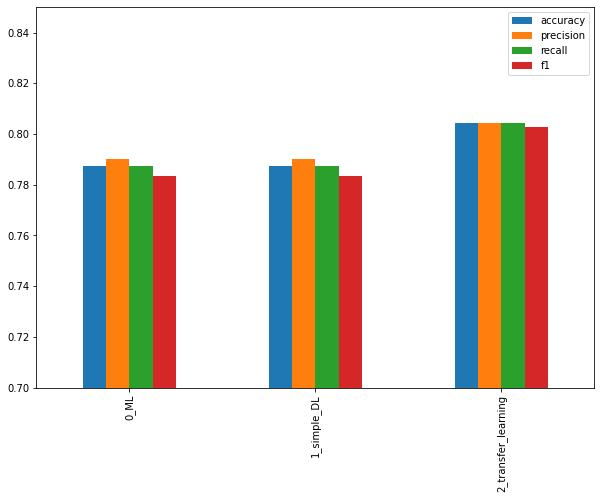

In [50]:
# Plot and compare all of the model results
models_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));
plt.ylim((0.7,0.85));

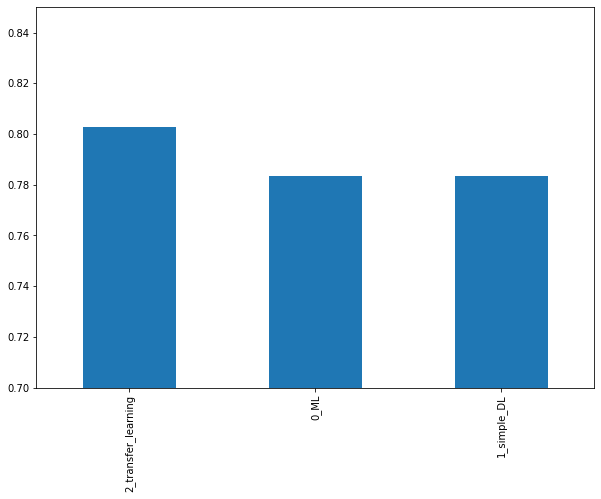

In [52]:
# Create another plot that only shows the F1-Score
models_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));
plt.ylim((0.7,0.85));

### Based on prediction speed

In [54]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples=val_sentences):
  """
  Times how long a model take to maek prediction on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make prediction on samples
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # caculate the time duration (time between finish and start times)
  time_per_pred = total_time/len(samples) # calculates time per one prediction
  return total_time, time_per_pred

In [58]:
# Caculate TF Hub Sentence Encoder time per pred
model_0_total_pred_time, model_0_time_per_pred = pred_timer(model_0)
model_1_total_pred_time, model_1_time_per_pred = pred_timer(model_1)
model_2_total_pred_time, model_2_time_per_pred = pred_timer(model_2)

# Create a DataFrame
pred_times = pd.DataFrame({"Model": ["Model_0", "Model_1", "Model_2"],
                           "Total Time": [model_0_total_pred_time, model_1_total_pred_time, model_2_total_pred_time],
                           "Time per prediction": [model_0_time_per_pred, model_1_time_per_pred, model_2_time_per_pred]})
pred_times

,Model,Total Time,Time per prediction
0,Model_0,0.073903,0.000097
1,Model_1,0.125293,0.000164
2,Model_2,0.432089,0.000567


Though Model_2 has a higher prediction time, the differece is not that big.

> Between the theree models, it seems that the transfer learning model is the best. Therefore, will continue using it for the rest of the notebook.

## Finding the most wrong examples 


In [59]:
# Create DataFrame with validation sentences and best performing model predictions labels + probabilites
val_df = pd.DataFrame({"text":val_sentences,
                       "target":val_labels,
                       "pred":model_2_preds,
                       "prob":tf.squeeze(model_2_pred_prob)})
val_df

,text,target,pred,prob
0,@samanthaturne19 IIt may logically have been t...,1,1.0,0.732531
1,@jasalhad @brianboru67 @Jimskiv92 @hijinks1967...,1,1.0,0.542538
2,Baby elephant dies just days after surviving m...,1,1.0,0.885686
3,British diver Neil Anthony Fears found dead by...,1,1.0,0.810076
4,The fear of the Lord is the start of knowledge...,0,0.0,0.057659
...,...,...,...,...
757,@ryanoss123 No worries you'd have to be on eve...,0,0.0,0.086108
758,@SirBrandonKnt exactly. That's why the lesnar/...,0,0.0,0.235290
759,Reddit Will Now Quarantine Offensive Content h...,1,0.0,0.049978
760,when you're taking a shower and someone flushe...,0,0.0,0.122992


In [61]:
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("prob", ascending=False)
most_wrong

,text,target,pred,prob
606,Mourning notices for stabbing arson victims st...,0,1.0,0.969773
578,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,0,1.0,0.937182
595,Have you ever seen the President \nwho killed ...,0,1.0,0.936328
260,San Jose Mercury: Governor Brown allows parole...,0,1.0,0.930695
530,The government is concerned about the populati...,0,1.0,0.914499
...,...,...,...,...
754,Next May I'll be free...from school from oblig...,1,0.0,0.065454
614,SANDSTORM!!! WOO HOO!!,1,0.0,0.051910
759,Reddit Will Now Quarantine Offensive Content h...,1,0.0,0.049978
342,If you're in search of powerful content to imp...,1,0.0,0.043670


In [67]:
# Check the false positives (model predicted 1 when it is supoosed to be 0)
for row in most_wrong[:5].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("\n=====\n")

Target: 0, Pred: 1, Prob: 0.9697728753089905
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe


=====

Target: 0, Pred: 1, Prob: 0.9371820688247681
Text:
HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ https://t.co/SeK6MQ6NJF


=====

Target: 0, Pred: 1, Prob: 0.9363275170326233
Text:
Have you ever seen the President 
who killed your wounded child?
Or the man that crashed your sister's plane 
claimin' he was sent of God?


=====

Target: 0, Pred: 1, Prob: 0.9306954145431519
Text:
San Jose Mercury: Governor Brown allows parole for California school bus hijacker  http://t.co/GpCeCp9kHv


=====

Target: 0, Pred: 1, Prob: 0.9144986867904663
Text:
The government is concerned about the population explosion and the population is concerned about the government explosion. - Joe Moore


=====



In [70]:
# Check the false negatives (model predicted 0 when it is supoosed to be 1)
for row in most_wrong[-5:][::-1].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("\n=====\n")

Target: 1, Pred: 0, Prob: 0.02235489897429943
Text:
Oh the usual. Mass murder and world domination plans over coffee. How's your day going?


=====

Target: 1, Pred: 0, Prob: 0.0436701737344265
Text:
If you're in search of powerful content to improve your business or have been frustrated with the deluge of 'quantitÛ_https://t.co/64cyMG1lTG


=====

Target: 1, Pred: 0, Prob: 0.04997824504971504
Text:
Reddit Will Now Quarantine Offensive Content http://t.co/LTmgdP6Jaf


=====

Target: 1, Pred: 0, Prob: 0.051909856498241425
Text:
SANDSTORM!!! WOO HOO!!


=====

Target: 1, Pred: 0, Prob: 0.06545382738113403
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...


=====



## Prepare for sumbssion 

In [73]:
# View the test dataset
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [82]:
# Get the test sentences
test_sentences = test_df["text"].to_list()

# Use the model to make predictions
test_pred_probs = model_2.predict(test_sentences)
# Convert the prediction probabilities into predictions
test_preds = tf.squeeze(tf.round(test_pred_probs))

In [86]:
# Create the submission dataset
sub_df = pd.DataFrame({"id":test_df["id"],
                       "target":test_preds})

# Convert the target column from floats to ints
sub_df["target"] = sub_df["target"].astype(int)

sub_df

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [87]:
sub_df.to_csv("submission.csv", index=False)

In [88]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> Kaggle's Score = Score: 0.81152